Task at hand is to predict the likelihood of admission

In [1]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np

We are dealing with labelled data that is continuous so our model will be a supervised regression model

<h2> Get the Data

In [2]:
df = pd.read_csv("Data/Admission_Predict_Ver1.1.csv")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
# indexing on Serial No.
df.set_index('Serial No.', inplace = True)

<h2> Explore Data

In [4]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


The data has 7 total attributes:
1. GRE Score (340 max)
2. TOEFL Score (120 max)
3. University Rating (5 max)
4. Statement of Purpose (5 max)
5. Letter of Reccomendation (5 max)
6. Undergraduate GPA (10 max)
7. Research Experience (1 max)

In [5]:
# luckily we're only dealing with numbers and clean up of NaN values/invalid values is unecessary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB


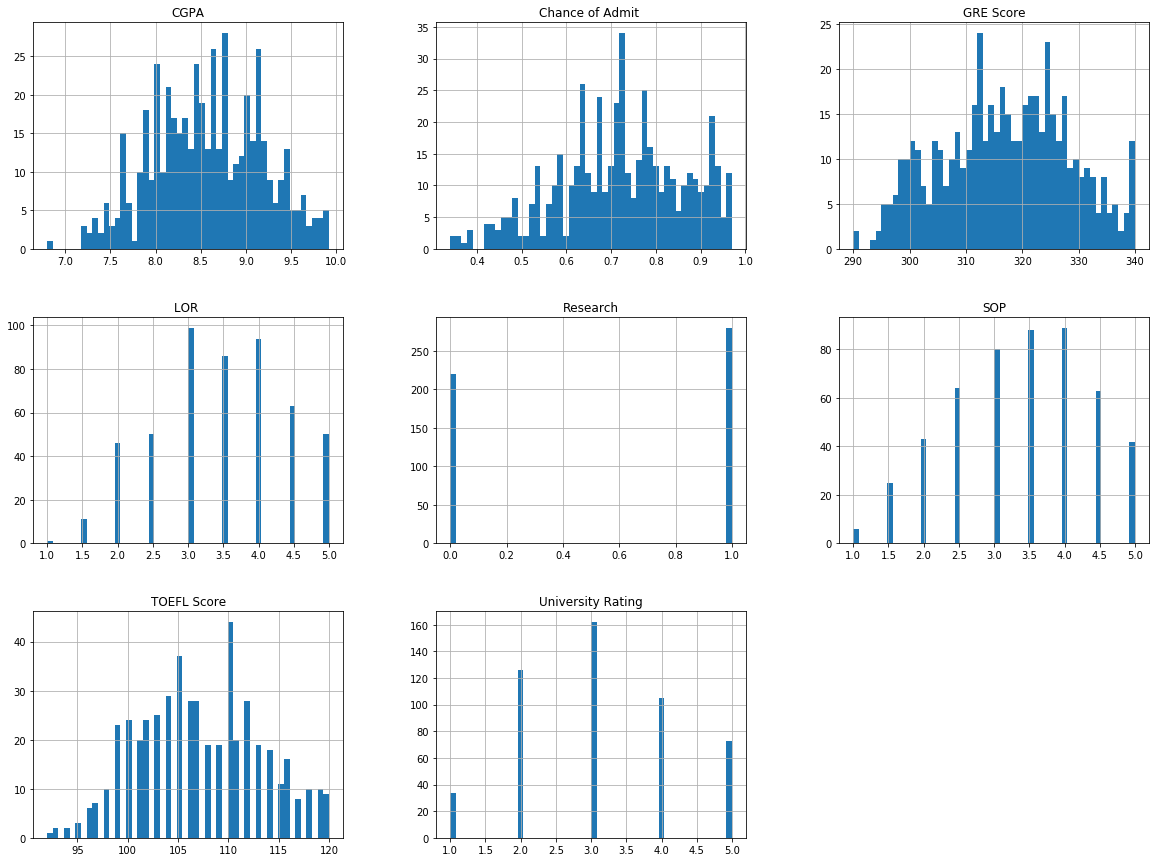

In [6]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

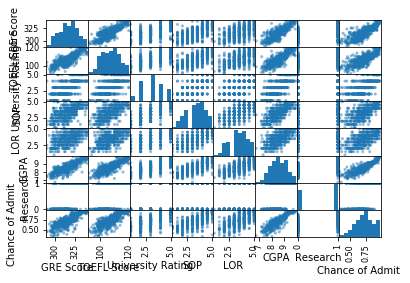

In [7]:
scatter_matrix(df)
plt.show()

From first glance it seems that the chance of admission has a strong correlation with:
1. CGPA
2. LOR
3. SOP
4. TOEFL score
5. GRE score 

and a weak correlation with:
1. University rating 
2. Research

Let's check the correlation coefficient between the different attributes:

In [8]:
corr_matrix = df.corr()
corr_matrix["Chance of Admit "].sort_values(ascending = False)

Chance of Admit      1.000000
CGPA                 0.882413
GRE Score            0.810351
TOEFL Score          0.792228
University Rating    0.690132
SOP                  0.684137
LOR                  0.645365
Research             0.545871
Name: Chance of Admit , dtype: float64

It seems like the TOEFL score, GRE score and CGPA have the highest correlation with university admittance. However, let's look at how all attributes relate to each other

In [9]:
corr_matrix

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL Score,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
University Rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance of Admit,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


From a quick glance, it appears that all attributes are related, either strongly or weakly, to other attributes. Fortunately, this should not affect the predictive power of our machine learning model. 

Now creating the training and testing set. Because of our extremely small dataset sample (500 entries total), we will split on the training and testing set on a 3:1 ratio to prevent overfitting of our model.

In [10]:
train_set, test_set = train_test_split(df, test_size = 0.25, random_state = 42)
# training set
X_train = train_set.values[:,0:7]
y_train = train_set.values[:,7]

# test set
X_test = test_set.values[:,0:7]
y_test = test_set.values[:,7]

<h2> Preparing Data

both min-max and StandardScaler will be used and compared. Note that both scalers are fit on the training data set and then applied to the test set as well. 

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

minmax_scaler = MinMaxScaler(feature_range = (0, 1)).fit(X_train)
standard_scaler = StandardScaler().fit(X_train)

# Min-Max 
X_train_MM = minmax_scaler.transform(X_train)
X_test_MM = minmax_scaler.transform(X_test)

# Standard Scaler
X_train_ST = standard_scaler.transform(X_train)
X_test_ST = standard_scaler.transform(X_test)

<h2> Model Creation

Several models will be compared:
1. Ridge Regression
2. Lasso Regression
3. Elastic Net
4. SVM
5. Decision Tree

In [12]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor 

models = []
models += [['Ridge', Ridge(alpha = 0.9, solver = "cholesky")]]
models += [['Lasso', Lasso(alpha = 1)]]
models += [['Elastic Net', ElasticNet(alpha = 0.1, l1_ratio = 0.25)]]
models += [['SVM', LinearSVR()]]
models += [['Tree', DecisionTreeRegressor()]]

<h4> Min Max
    

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold = KFold(n_splits = 5, random_state = 42)
result_MM =[]
names = []

for name, model in models:
    cv_score = -1 * cross_val_score(model, X_train_MM, y_train, cv = kfold, scoring = 'neg_root_mean_squared_error')
    result_MM +=[cv_score]
    names += [name]
    print('%s: %f (%f)' % (name,cv_score.mean(), cv_score.std()))

Ridge: 0.061186 (0.005671)
Lasso: 0.141600 (0.008727)
Elastic Net: 0.131181 (0.009215)
SVM: 0.061313 (0.005627)
Tree: 0.088391 (0.006601)


C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear

From this, it seems like Ridge linear regression is the best choice (RMSE = 0.061186) with SVM in close second place (RMSE = 0.061156). Note that the constant -1 was multiplied to the cross_val_score simply to make the RMSE positive

<h4> Standard Scaler

In [14]:
result_ST =[]
for name, model in models:
    cv_score = -1 * cross_val_score(model, X_train_ST, y_train, cv = kfold, scoring = 'neg_root_mean_squared_error')
    result_MM +=[cv_score]
    print('%s: %f (%f)' % (name,cv_score.mean(), cv_score.std()))

Ridge: 0.060759 (0.006088)
Lasso: 0.141600 (0.008727)
Elastic Net: 0.068626 (0.005010)
SVM: 0.061536 (0.005817)
Tree: 0.090234 (0.005156)


C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

Once again, Ridge and SVM are the top two models with respective RMSE scores of 0.060759 and 0.061416. Using both Min Max and StandardScaler, Ridge Regression seems to have the least amount of error in both cases so let us continue with this model

In [30]:
y.shape

(75,)

<h2> Evaluation

In [31]:
# training the models
Ridge_model_MM = Ridge(alpha = 0.9, solver = "cholesky").fit(X_train_MM, y_train)
Ridge_model_ST = Ridge(alpha = 0.9, solver = "cholesky").fit(X_train_ST, y_train)

# getting predictions
predictions_MM = Ridge_model_MM.predict(X_test_MM)
predictions_ST = Ridge_model_ST.predict(X_test_ST)

Now evaluating our models

In [32]:
from sklearn.metrics import mean_squared_error
print("Ridge, Min Max: " + str(mean_squared_error(y_test, predictions_MM)))
print("Ridge, Standard Scaler: " + str(mean_squared_error(y_test, predictions_ST)))

Ridge, Min Max: 0.0035895096044584913
Ridge, Standard Scaler: 0.003584168912401828


Using Standard Scaler results in a lower RMSE score, so our final model to choose to predict university admission is Ridge Regression model <br>

P.S. This is my first ever Kaggle submission, please give me comments/advice/areas to improve on!